In [1]:
experiment_setup_name = "musicians_category_example"

In [2]:
import sys,os
sys.path.append("..")

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

#the problem is too small for GPU
%env THEANO_FLAGS='device=cpu'

import theano
import theano.tensor as T
import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [3]:

from config import snapshot_path

floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* 1000 нейронов
* с epsilon-greedy обучением
* Тупой SGD с Nesterov Mommentum


Много вспомогательного кода

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 434 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [4]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


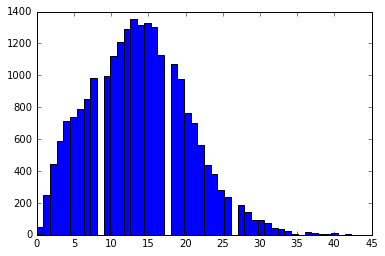

In [5]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [6]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [7]:
from sklearn.cross_validation import train_test_split

In [8]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [9]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.99,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 85
контрольная выборка: 8509


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [10]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = self._attributes.shape[0]
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32')
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    
    
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [11]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [12]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [13]:
import lasagne

n_hid=100


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")
#memory
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [14]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],)
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [15]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



INFO (theano.gof.compilelock): Waiting for existing lock by process '15124' (I am process '15647')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jheuristic/.theano/compiledir_Linux-3.10--x86_64-with-Ubuntu-12.04-precise-x86_64-2.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15124' (I am process '15647')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jheuristic/.theano/compiledir_Linux-3.10--x86_64-with-Ubuntu-12.04-precise-x86_64-2.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15124' (I am process '15647')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jheuristic/.theano/compiledir_Linux-3.10--x86_64-with-Ubuntu-12.04-precise-x86_64-2.7.3-64/lock_dir


# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [16]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [17]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [18]:
#get pairs of corresponding [predicted Qvalues, reference Qvalues] to train on

is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)

ref_tuples = env.get_reference(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_Qvalues, predicted_Qvalues, is_end = ref_tuples

In [19]:
#concatenate "alive" ticks from all sessions to then compute errors

to_be_raveled = [action_seq,rewards_seq,action_Qvalues, predicted_Qvalues, is_end]

raveled_tuples = env.ravel_alive(is_alive_seq,*to_be_raveled)

action_ids_ravel,immediate_rewards_ravel,action_Qvalues_ravel,\
reference_Qvalues_ravel,is_end_ravel= raveled_tuples



from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,action_Qvalues_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [23]:
_updates = lasagne.updates.nesterov_momentum(loss,
                                             weights,learning_rate=0.05,momentum=0.5)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [24]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [25]:
evaluation_fun = theano.function([],[action_ids_ravel,action_Qvalues_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [1]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


NameError: name 'data_attrs' is not defined

# training

In [27]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [28]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
 * раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 100,loss 0.58221, greed 0.20300, rewards: ( train -19.54203, det_train 0.00000) 
rec 0.581 reg 0.001
epoch 200,loss 0.92026, greed 0.20598, rewards: ( train -16.95463, det_train 0.10000) 
rec 0.919 reg 0.001
epoch 300,loss 0.37756, greed 0.20896, rewards: ( train -16.39914, det_train 0.12333) 
rec 0.377 reg 0.001
epoch 400,loss 1.34905, greed 0.21192, rewards: ( train -15.66374, det_train 0.31100) 
rec 1.348 reg 0.001
epoch 500,loss 0.80245, greed 0.21488, rewards: ( train -16.68901, det_train 0.37990) 
rec 0.801 reg 0.001
epoch 600,loss 0.71388, greed 0.21782, rewards: ( train -15.85646, det_train 0.50858) 
rec 0.713 reg 0.001
epoch 700,loss 0.30392, greed 0.22076, rewards: ( train -16.45579, det_train 0.69105) 
rec 0.303 reg 0.001
epoch 800,loss 0.53309, greed 0.22368, rewards: ( train -16.05287, det_train 0.92195) 
rec 0.532 reg 0.001
epoch 900,loss 0.86301, greed 0.22660, rewards: ( train -14.13550, det_train 1.09642) 
rec 0.862 reg 0.001
Evaluation:

deterministic
#26: decad

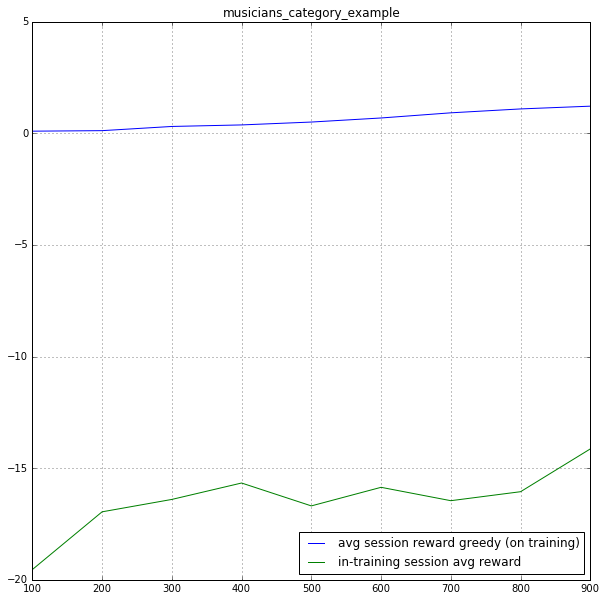

epoch 1000,loss 0.46587, greed 0.22951, rewards: ( train -6.83838, det_train 1.22011) 
rec 0.465 reg 0.001
epoch 1100,loss 0.56037, greed 0.23240, rewards: ( train -15.60031, det_train 1.13143) 
rec 0.559 reg 0.001
epoch 1200,loss 0.58857, greed 0.23529, rewards: ( train -15.14575, det_train 0.78496) 
rec 0.588 reg 0.001
epoch 1300,loss 0.46467, greed 0.23817, rewards: ( train -14.95442, det_train 0.97313) 
rec 0.464 reg 0.001
epoch 1400,loss 0.55008, greed 0.24104, rewards: ( train -15.15212, det_train 0.97581) 
rec 0.549 reg 0.001
epoch 1500,loss 0.55684, greed 0.24389, rewards: ( train -14.89370, det_train 1.17823) 
rec 0.556 reg 0.001
epoch 1600,loss 0.52033, greed 0.24674, rewards: ( train -15.04467, det_train 1.32708) 
rec 0.519 reg 0.001
epoch 1700,loss 0.58304, greed 0.24958, rewards: ( train -13.98375, det_train 1.72770) 
rec 0.582 reg 0.001
epoch 1800,loss 0.38588, greed 0.25241, rewards: ( train -15.63629, det_train 1.78827) 
rec 0.385 reg 0.001
epoch 1900,loss 0.49737, gree

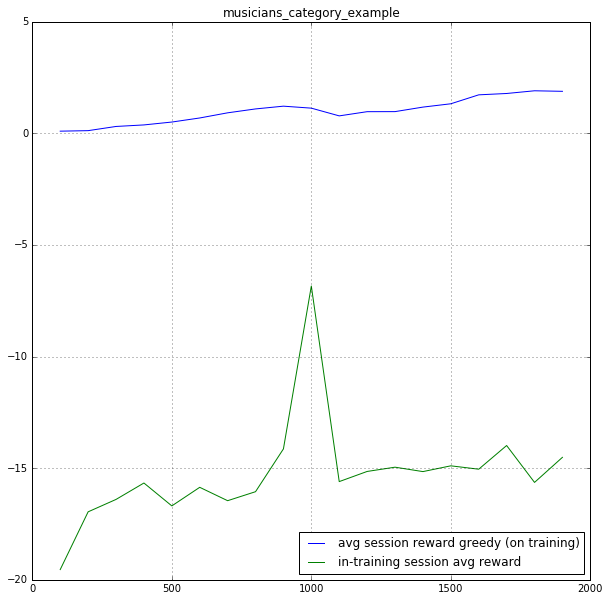

epoch 2000,loss 0.46287, greed 0.25804, rewards: ( train -15.30802, det_train 1.88516) 
rec 0.462 reg 0.001
epoch 2100,loss 0.53729, greed 0.26085, rewards: ( train -10.28446, det_train 2.02998) 
rec 0.536 reg 0.001
epoch 2200,loss 0.67183, greed 0.26364, rewards: ( train -14.25713, det_train 1.86031) 
rec 0.671 reg 0.001
epoch 2300,loss 1.04815, greed 0.26642, rewards: ( train -14.28996, det_train 2.07428) 
rec 1.047 reg 0.001
epoch 2400,loss 0.89956, greed 0.26920, rewards: ( train -14.31883, det_train 2.10019) 
rec 0.898 reg 0.001
epoch 2500,loss 0.40552, greed 0.27196, rewards: ( train -13.46501, det_train 2.22350) 
rec 0.404 reg 0.001
epoch 2600,loss 0.26904, greed 0.27472, rewards: ( train -14.88139, det_train 2.26782) 
rec 0.268 reg 0.001
epoch 2700,loss 0.31579, greed 0.27746, rewards: ( train -14.56151, det_train 2.27437) 
rec 0.315 reg 0.001
epoch 2800,loss 0.70124, greed 0.28020, rewards: ( train -13.74594, det_train 2.38027) 
rec 0.700 reg 0.001
epoch 2900,loss 0.36992, gre

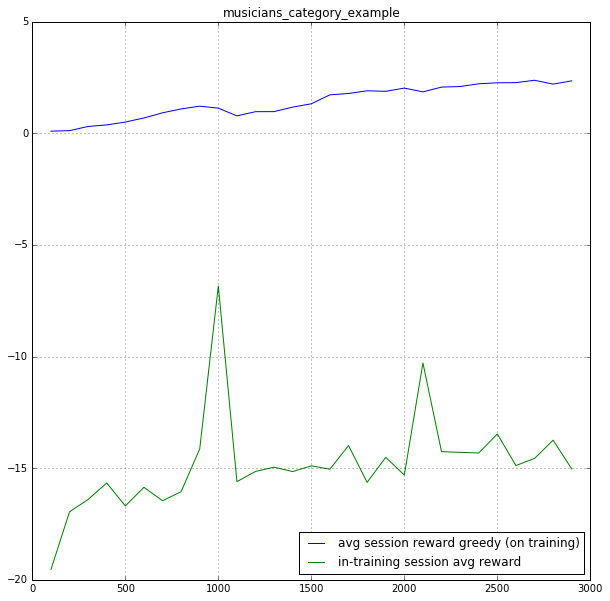

epoch 3000,loss 0.29538, greed 0.28565, rewards: ( train -14.68036, det_train 2.35468) 
rec 0.294 reg 0.001
epoch 3100,loss 0.27162, greed 0.28836, rewards: ( train -14.86229, det_train 2.48588) 
rec 0.271 reg 0.001
epoch 3200,loss 0.36465, greed 0.29106, rewards: ( train -12.14251, det_train 2.73729) 
rec 0.364 reg 0.001
epoch 3300,loss 0.45664, greed 0.29375, rewards: ( train -13.23679, det_train 2.89690) 
rec 0.456 reg 0.001
epoch 3400,loss 0.72751, greed 0.29643, rewards: ( train -14.27837, det_train 2.90721) 
rec 0.726 reg 0.001
epoch 3500,loss 0.45879, greed 0.29911, rewards: ( train -13.84465, det_train 2.84982) 
rec 0.458 reg 0.001
epoch 3600,loss 0.34724, greed 0.30177, rewards: ( train -13.32066, det_train 2.99817) 
rec 0.346 reg 0.001
epoch 3700,loss 0.33395, greed 0.30443, rewards: ( train -13.61218, det_train 3.13169) 
rec 0.333 reg 0.001
epoch 3800,loss 0.36541, greed 0.30708, rewards: ( train -10.12254, det_train 3.08519) 
rec 0.364 reg 0.001
epoch 3900,loss 0.41186, gre

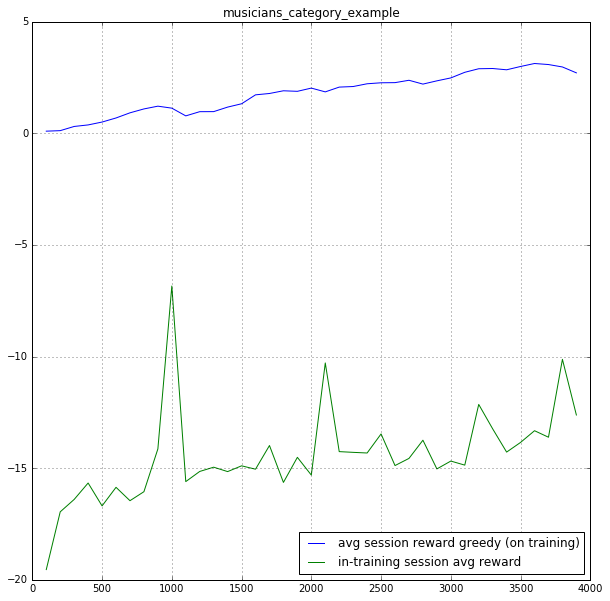

epoch 4000,loss 0.37675, greed 0.31234, rewards: ( train -12.92296, det_train 2.71233) 
rec 0.376 reg 0.001
epoch 4100,loss 0.35000, greed 0.31497, rewards: ( train -13.49033, det_train 2.74110) 
rec 0.349 reg 0.001
epoch 4200,loss 0.44841, greed 0.31758, rewards: ( train -12.80669, det_train 2.70032) 
rec 0.447 reg 0.001
epoch 4300,loss 0.43793, greed 0.32018, rewards: ( train -12.90310, det_train 2.79696) 
rec 0.437 reg 0.001
epoch 4400,loss 0.25740, greed 0.32278, rewards: ( train -12.10940, det_train 2.85060) 
rec 0.256 reg 0.001
epoch 4500,loss 0.41269, greed 0.32536, rewards: ( train -11.77905, det_train 3.16554) 
rec 0.412 reg 0.001


In [ ]:
n_epochs = 50000
batch_size=3
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/30000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 5000 ==0:
        save(resolver,"{}.epoch{}.pcl".format(os.path.join(snapshot_path, experiment_setup_name),
                                              epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


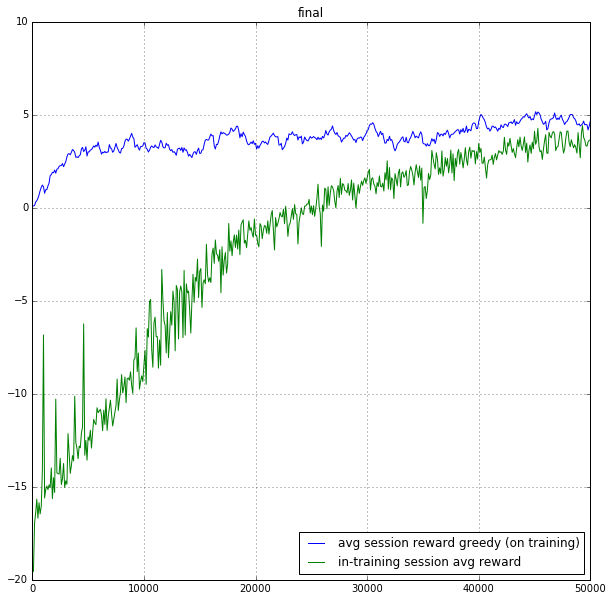

In [34]:
plot_scores("final")

In [35]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

#149: Labels:is_known (4.008) -> 1.0 | #247: Website:is_known (3.576) -> 1.0 | #260: decades_active:1990 (3.410) -> 1.0 | #26: decades_active:2010 (2.920) -> 1.0 | #25: last_activity:still_active (2.197) -> 1.0 | #166: decades_active:2000 (1.296) -> 1.0 | #1: Birth name:is_known (0.545) -> 1.0 | #393: <end_session_action> (-0.001) -> 0.0 | <end>
true: category:List_of_roots_reggae_artists category:List_of_reggae_musicians category:List_of_singer-songwriters

#149: Labels:is_known (4.008) -> 1.0 | #50: Genres:bop (2.366) -> -1.0 | #247: Website:is_known (3.677) -> 1.0 | #260: decades_active:1990 (3.365) -> 1.0 | #26: decades_active:2010 (2.960) -> 1.0 | #25: last_activity:still_active (2.168) -> 1.0 | #71: first_activity:1962 (0.619) -> -1.0 | #166: decades_active:2000 (1.268) -> 1.0 | #1: Birth name:is_known (0.370) -> -1.0 | #393: <end_session_action> (-0.004) -> 0.0 | <end>
true: category:List_of_Latin_pop_artists

#149: Labels:is_known (4.008) -> -1.0 | #91: decades_active:1980 (3.8

#149: Labels:is_known (4.008) -> 1.0 | #247: Website:is_known (3.576) -> 1.0 | #119: Instruments:accordion (2.104) -> -1.0 | #260: decades_active:1990 (3.198) -> 1.0 | #26: decades_active:2010 (2.853) -> 1.0 | #25: last_activity:still_active (2.135) -> 1.0 | #166: decades_active:2000 (1.325) -> 1.0 | #1: Birth name:is_known (0.521) -> 1.0 | #393: <end_session_action> (-0.004) -> 0.0 | <end>
true: category:List_of_roots_reggae_artists category:List_of_reggae_musicians category:List_of_singer-songwriters


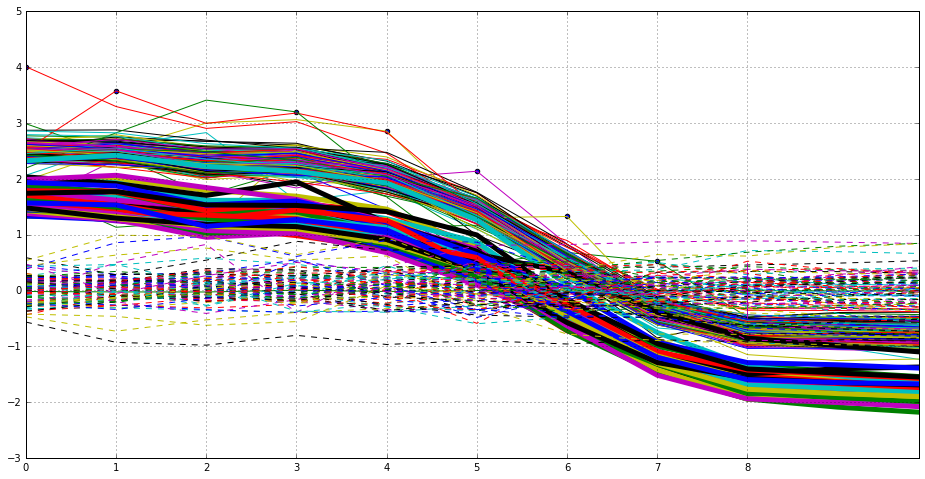


#149: Labels:is_known (4.008) -> 1.0 | #247: Website:is_known (3.576) -> 1.0 | #260: decades_active:1990 (3.410) -> 1.0 | #26: decades_active:2010 (2.920) -> 1.0 | #25: last_activity:still_active (2.197) -> 1.0 | #166: decades_active:2000 (1.296) -> 1.0 | #1: Birth name:is_known (0.545) -> -1.0 | #393: <end_session_action> (0.001) -> 0.0 | <end>
true: category:List_of_Latin_pop_artists


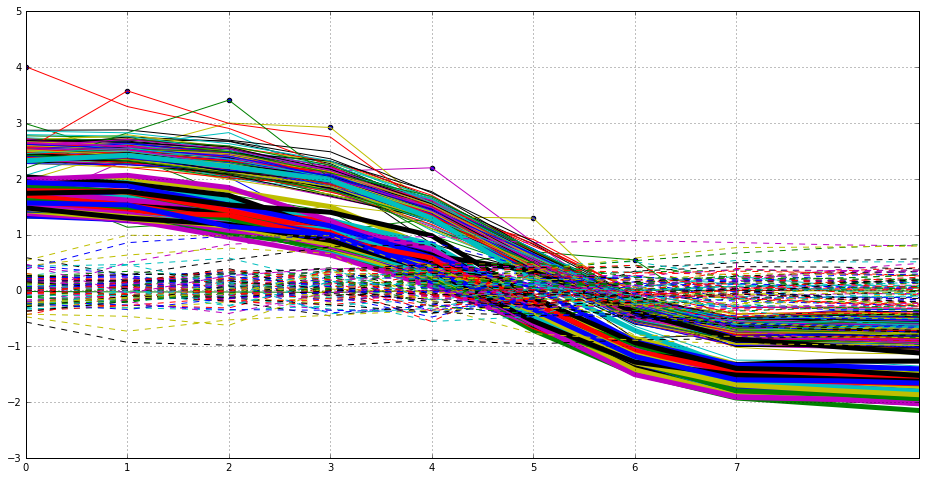


#149: Labels:is_known (4.008) -> -1.0 | #91: decades_active:1980 (3.838) -> -1.0 | #164: last_activity:2007 (1.651) -> -1.0 | #301: category:List_of_flautists (0.446) -> -2.0 | #26: decades_active:2010 (2.485) -> -1.0 | #239: Died:is_known (1.407) -> 1.0 | #221: decades_active:1970 (0.271) -> -1.0 | #108: Genres:r&b (-0.863) -> -1.0 | #393: <end_session_action> (0.009) -> 0.0 | <end>
true: category:List_of_clarinetists category:List_of_nicknames_of_jazz_musicians category:List_of_jazz_saxophonists category:List_of_musicians_from_Chicago category:List_of_saxophonists


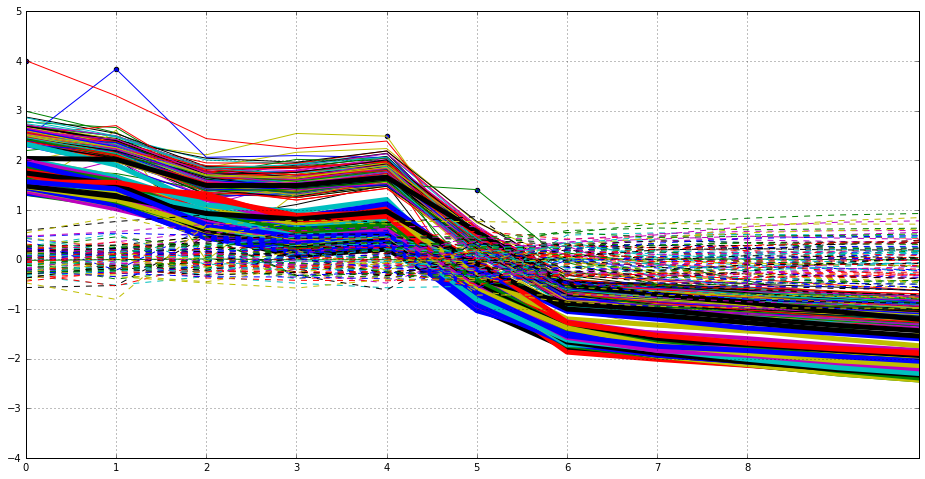

In [36]:
print_session(display=True,legend=False)